# HW6 Spike sorting
* Read this page: https://en.wikipedia.org/wiki/Spike_sorting#:~:targetText=Spike%20sorting%20is%20a%20class,neurons%20from%20background%20electrical%20noise. 
* Use dimensionality reduction techniques and clustering algorithms to identify groups of similar spikes
* For instance: 
    * TRY DIFFERENT THRESHOLDS TO EXTRACT SPIKES (change tf parameter)
    * DO PCA
    * DO KMEANs
    * Visualize average waveform associated to each spike: 
        * plt.plot(mean(waveform[labels==0], axis=0))
        
* How many waveforms (neurons/units) are there?
* Plot the clustering result against the first 2 principal components
* Plot the average waveform of each neuron overlaid

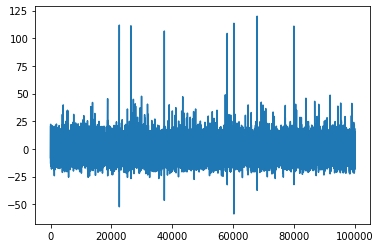

In [699]:
import numpy as np
import pylab as plt
trace = np.load('spike_sort/simulation_1.npy')
plt.plot(trace[:100000])
plt.show()

In [700]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=350):
    # extract spike waveforms
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) *tf

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0]
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]

            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i

                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]

                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)

    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]

    return spike_samp, wave_form

In [701]:
spike_samp, wave_form = get_spikes(trace, tf=6.09)

In [757]:
spike_samp, wave_form_med = get_spikes(trace, tf=5.7)

In [756]:
spike_samp, wave_form_low = get_spikes(trace, tf=5.4)

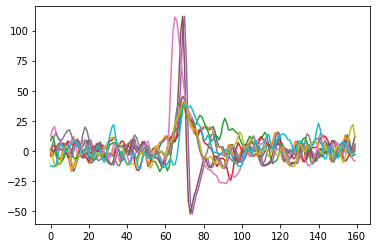

In [755]:
plt.plot(wave_form[:10].T)

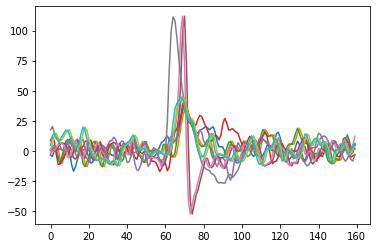

In [758]:
plt.plot(wave_form_med[:10].T)

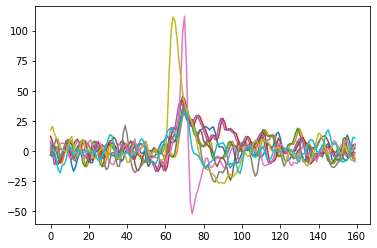

In [759]:
plt.plot(wave_form_low[:10].T)

Below we plot the average trace after extracting spikes at varying thresholds.
I continue on with the highest threshold, the average of this is represented by the blue trace

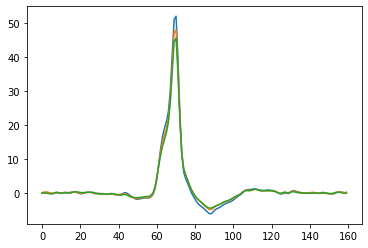

In [760]:
plt.plot(wave_form[:].mean(axis=0))
plt.plot(wave_form_med[:].mean(axis=0))
plt.plot(wave_form_low[:].mean(axis=0))

# PCA

In [761]:
from sklearn.decomposition import PCA

pca = PCA(n_components=45)
X_reduced = pca.fit_transform(wave_form.T)

Now we plot the first two priniciple components against each other and see that there are three separate neurons in our data

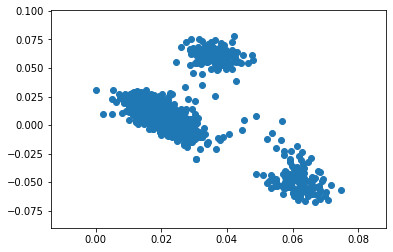

In [762]:
plt.scatter(pca.components_[0],pca.components_[1])

The above scatterplot indicates that **three** separate clusters of spikes were detected, indicating that there are three neurons in our spike trace.

# KMEANS

Here I use KMeans to separate neural units by spike shape.
With a function written below that does the following:
    - plotSpikeType does KMeans with a specified number of clusters and plots the average wave form for each cluster of neurons 

In [763]:
from sklearn.cluster import KMeans

# now we use kmeans to separate spikes by clustering
# first we write a function to do this for us for a single cluster value


def plotSpikeType(wave_form, clusters):

    kmeans = KMeans(n_clusters=clusters, random_state=42)
    ypred = kmeans.fit_predict(wave_form)
    
    means_by_spike_type = np.zeros((clusters,wave_form.shape[1]))
    number_of_each_spike = np.zeros((clusters))

    for spike_type in range(clusters):
        for row in range(wave_form.shape[0]):
            if (int(spike_type) == ypred[row]):
                number_of_each_spike[spike_type] = number_of_each_spike[spike_type] + 1
                means_by_spike_type[spike_type,:] = wave_form[row,:] + means_by_spike_type[spike_type,:]

    for spike_type in range(clusters):
        means_by_spike_type[spike_type,:] = means_by_spike_type[spike_type,:]/number_of_each_spike[spike_type]
        
    for spike_type in range(clusters):
        plt.plot(means_by_spike_type[spike_type,:], label = 'KMeans Extracted Waveform ' + str(spike_type+1))
        plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right', fontsize='large')

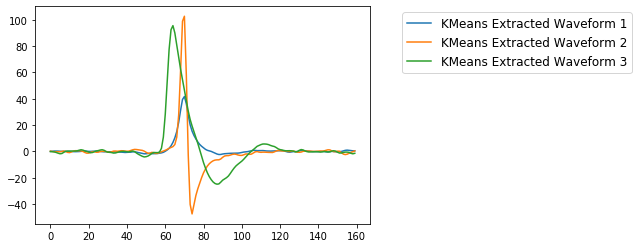

In [764]:
# lets see what this looks like with three clusters to match our number determined
# by PCA

clusters = 3
plotSpikeType(wave_form, clusters)

# LLE for determining number of neurons

In [784]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=5, random_state=42)
X_reduced3= lle.fit_transform(wave_form.T)
X_reduced3.shape

(160, 2)

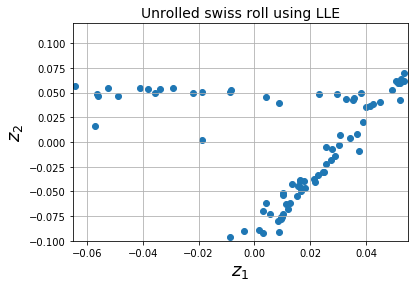

In [789]:
plt.title("waveform separation using LLE", fontsize=14)
plt.scatter(X_reduced3[:, 0], X_reduced3[:, 1], cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

LLE seems to only detect two neurons

# Isomap

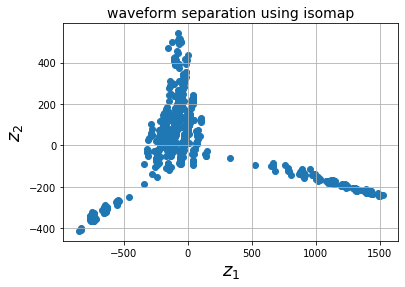

In [793]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(wave_form)

plt.title("waveform separation using isomap", fontsize=14)
plt.scatter(X_reduced_isomap[:, 0], X_reduced_isomap[:, 1], cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True)
plt.show()

Isomap gives us a singular large cluster, with smaller stretched regions that could also represent distinct groups.